# Welcome to `bruges`

**This page gives a quick look at some of the things `bruges` can do.**

This library does all sorts of things so it's hard to show you a single workflow and say, "here's how to use `bruges`". But making a simple wedge model will let us show you several features, and maybe it will help you see how to use `bruges` in your own work.

Seismic wedge models provide seismic interpreters a quantitative way of studying thin-bed stratigraphy at or below seismic resolution. Here's the workflow:

1. Define the layer geometries.
1. Give those layers rock properties.
1. Calculate reflection coefficients.
1. Make a seismic wavelet.
1. Model the seismic response by convolving the reflectivities with the wavelet. 

Let's get started!

## Make a wedge

The `wedge` function in `models` submodule allows you to generate a variety of stratigraphic geometries. The default gives us a model `m` which is a 2-D NumPy array of size `(100, 100)`. It has 3 layers in it.

In [1]:
import bruges as bg

m, top, base, ref = bg.models.wedge(width=120)

The `wedge` function returns a tuple containing the model `m`, as well as the a `top`, `base` and `ref` denoting some key boundaries in the model. Let's put these objects on a plot.

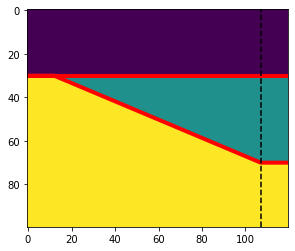

In [2]:
import matplotlib.pyplot as plt

plt.imshow(m)
plt.plot(top, 'r', lw=4)
plt.plot(base, 'r', lw=4)
plt.axvline(ref, c='k', ls='--')
plt.show()

The model `m` is a 2-D NumPy array where each element is an index corresponding to each layer. The purple layer region has `0`, the green layer has `1` and the yellow layer is `2` . `top` and `base`, shown in red, are the depths down to the "top" of wedge layer and "base" of the wedge layer respectively. `ref` stands for "reference trace" and it denotes the position where the wedge has a thickness factor of 1.

## Make an earth

The model is filled with integers, but the earth is filled with rock properties. We need to replace those integers with rock properties.

Let's define P-wave velocity, S-wave velocity, and rho (density) for our 3 rock types:

In [3]:
import numpy as np

vps = np.array([2320, 2350, 2350])
vss = np.array([1150, 1250, 1200])
rhos = np.array([2650, 2600, 2620])

We can use these to make `vp` and `rho` earth models. We can use NumPy's fancy indexing by passing our array of indicies to access the rock properties (in this case acoustic impedance) for every element at once. 

In [4]:
vp = vps[m]
vs = vss[m]
rho = rhos[m]

And plot the acoustic impedance to check it looks reasonable:

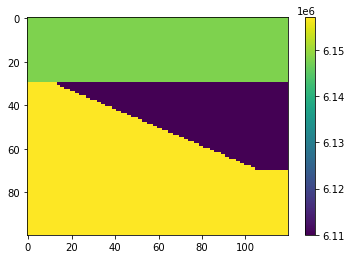

In [5]:
impedance = vp * rho

plt.imshow(impedance, interpolation='none')
plt.colorbar()
plt.show()

## Acoustic reflectivity

We don't actually need impedance, we need reflectivity. We can use `bruges` to create a section of normal incidence reflection coefficient; this will be what we convolve with a wavelet. 

Here's how to get the acoustic reflectivity:

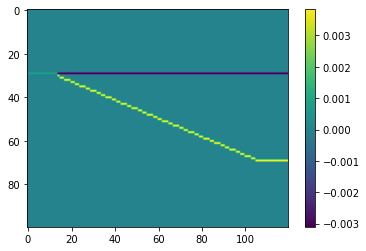

In [6]:
rc = bg.reflection.acoustic_reflectivity(vp, rho)

plt.imshow(rc)
plt.colorbar()
plt.show()

The reflections coeffients are zero almost everywhere, except at the layer boundaries. The reflection coefficient between layer 1 and layer 2 is a negative, and between layer 2 and layer 3 is a positive number. This will determine the scale and polarity of the seismic amplitudes. 

## Offset reflectivity

We can also calculate the exact Zoeppritz offset reflectivity. For example, to compute the reflectivity at 10 degrees of offset &mdash; note that this results in complex numbers, so we'll only use the real part in the plot:

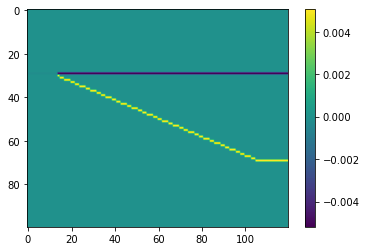

In [7]:
rc_10 = bg.reflection.reflectivity(vp, vs, rho, theta=10)

plt.imshow(rc_10.real)
plt.colorbar()
plt.show()

As with the elastic impedance calculation, we can create a range of angles at once:

In [8]:
rc = bg.reflection.reflectivity(vp, vs, rho, theta=np.arange(60), method='shuey')

rc.shape

(60, 100, 120)

The 10-degree reflectivity we computed before is in there as `rc[10]`, but we can also see how reflectivity varies with angle:

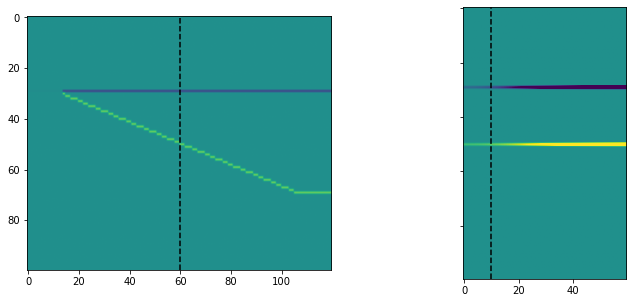

In [9]:
offset = 10  # degrees
trace = 60

fig, axs = plt.subplots(ncols=2, figsize=(12, 5), sharey=True)
axs[0].imshow(rc[offset].real, vmin=-0.01, vmax=0.01)
axs[0].axvline(trace, c='k', ls='--')
axs[1].imshow(rc[:, :, trace].real.T, vmin=-0.01, vmax=0.01)
axs[1].axvline(offset, c='k', ls='--')
plt.show()

## A 1D wavelet

Let's create a Ricker wavelet to serve as our seismic pulse. We specify it has a length of 0.256 s, a sample interval of 0.002 s, and corner frequencies of 8, 12, 20, and 40 Hz:

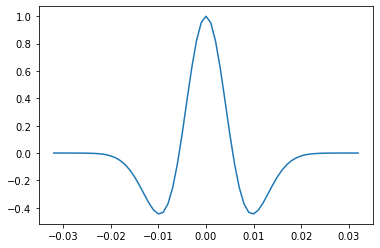

In [10]:
w, t = bg.filters.ricker(0.064, 0.001, 40)

plt.plot(t, w)

## A 2D wavelet bank

There are several wavelet functions; they can all take a sequence of frequencies and produce all of them at once as a filter bank:

Text(0, 0.5, 'frequency [Hz]')

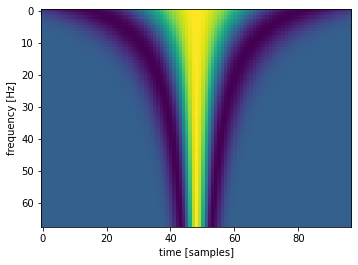

In [11]:
w_bank, t = bg.filters.ricker(0.096, 0.001, np.arange(12, 80))

plt.imshow(w_bank)
plt.xlabel('time [samples]')
plt.ylabel('frequency [Hz]')

## A 1D convolution

We can use `bruges` to perform a convolution.

Remember our RC series is 3D. Let's keep it simple for now and look at a single waveform from the reference location `ref` in our model. The synthetic seismic trace is band-limited filtering of the reflectivity spikes. When these spikes get closer together the waveforms will "tune" with one another and won't necessarily line up with the reflectivity series.

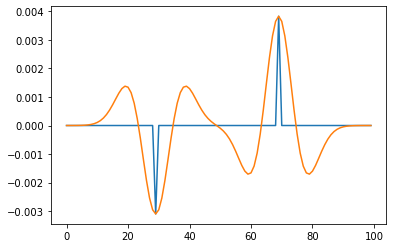

In [12]:
rc_ref = rc[0, :, ref]

syn = bg.filters.convolve(rc_ref, w)

plt.plot(rc_ref)
plt.plot(syn)
plt.show()

In the 1D case, it would have been easy enough to use `np.convolve` to do this. The equivalent code is:

    syn = np.convolve(rc_ref, w, mode='same')
    
## 2D convolution

But when the reflectivity is two-dimensional (or more!), you need to use `np.apply_along_axis` or some other trick to essentially loop over the traces. But don't worry! The `bruges` function will compute the convolution for you over all of the dimensions at once.

There's a small catch, because of how models are organized. For plotting convenience, time is on the first axis of a model slice or profile, not the last axis (as is usual with, say, seismic data &mdash; with the result that you typically have to transpose such data for display). So we have to tell the `convolve()` function which is our Z (time) axis:

In [13]:
syn = bg.filters.convolve(rc, w, axis=1)

syn.shape

(60, 100, 120)

Remember those are offsets in the first dimension. Let's look at the zero-offset synthetic alongside the 30-degree panel:

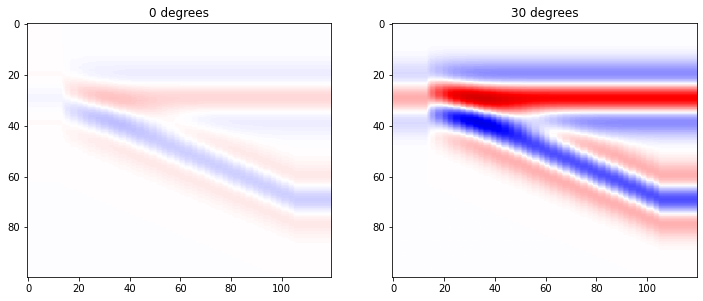

In [14]:
# A quick way to set a sensible max, so both panels have the same colours.
ma = np.percentile(syn, 99.9)

near, far = 0, 30

fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
axs[0].imshow(syn[near], cmap='seismic_r', vmin=-ma, vmax=ma)
axs[0].set_title(f'{near} degrees')
axs[1].imshow(syn[far], cmap='seismic_r', vmin=-ma, vmax=ma)
axs[1].set_title(f'{far} degrees')
plt.show()

Or we could look at a single 'angle gather':

Text(0.5, 0, 'angle')

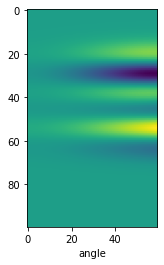

In [15]:
trace = 70

plt.imshow(syn[:, :, trace].T)
plt.xlabel('angle')

## Bend your mind

The convolution function will also accept a filter bank (a collection of wavelets at different frequencies). We made one earlier called `w_bank`.

Watch out: the result of this convolution will be 4-dimensional!

In [16]:
syn = bg.filters.convolve(rc, w_bank, axis=1)

syn.shape

(68, 60, 100, 120)

Notice that the time axis has moved back to dimension 2 as a result of the wavelet having two dimensions: its frequency dimension is now in dimension 0 of the array.

So we can look at the synthetic created with a 22 Hz wavelet (the wavelet bank started at 12 Hz, so this is slice 10 in the first dimension), and at 30 degrees of offset (slice 30 in the second dimension):

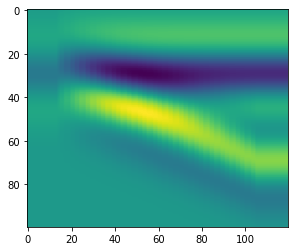

In [19]:
plt.imshow(syn[10, 30])

But we could also look at how the amplitude varies in the stratigraphic middle (timeslice `50`) of the thickest part of the wedge (trace `ref`), when we vary frequency and offset:

Text(0, 0.5, 'frequency')

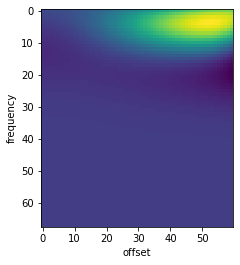

In [18]:
plt.imshow(syn[:, :, 50, ref])
plt.xlabel('offset')
plt.ylabel('frequency')

Not surprisingly, we only see amplitudes here at low frequencies (it's the middle of the wedge). Interestingly, we also need far offsets.

---
&copy; 2022 Agile Scientific, CC BY